# Import packages

In [ ]:
# Predicting Customer Churn in a Telco Company using
# Demographic and Service Data

# Authors:
# Justine George, Harshavardhini Sridhar
# Made in Google Colaboratory

import numpy as np
import pandas as pd
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import math
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import EditedNearestNeighbours
from sklearn.preprocessing import StandardScaler
import warnings
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, roc_curve, auc
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import confusion_matrix
warnings.filterwarnings("ignore")


# Load Dataset

In [ ]:
# Load csv from Github repo
cp = pd.read_csv('https://raw.githubusercontent.com/justinegeo96/Telco-Customer-Churn/main/WA_Fn-UseC_-Telco-Customer-Churn.csv')

# Dataset Description


In [ ]:
# Dimensions of the DataFrame - rows and columns
cp.shape

(7043, 21)

In [ ]:
# Quick overview of the dataset
cp.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Data Cleaning

In [ ]:
# Get a summary of the metadata of Dataframe
cp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [ ]:
# Check if any of the values are null
cp.isnull().any()

customerID          False
gender              False
SeniorCitizen       False
Partner             False
Dependents          False
tenure              False
PhoneService        False
MultipleLines       False
InternetService     False
OnlineSecurity      False
OnlineBackup        False
DeviceProtection    False
TechSupport         False
StreamingTV         False
StreamingMovies     False
Contract            False
PaperlessBilling    False
PaymentMethod       False
MonthlyCharges      False
TotalCharges        False
Churn               False
dtype: bool

In [ ]:
# Check for non-numeric values in all numeric features of the DataFrame
numeric_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in numeric_cols:
  non_numeric_rows = cp[pd.to_numeric(cp[col], errors='coerce').isnull()]
  print(f"Non-numeric rows for column '{col}':")
  print(len(non_numeric_rows))
  print()

Non-numeric rows for column 'tenure':
0

Non-numeric rows for column 'MonthlyCharges':
0

Non-numeric rows for column 'TotalCharges':
11



Inferences:
* The TotalCharges column contains 11 non-numeric values. To ensure data consistency, we should remove the corresponding rows that contain these values.


In [ ]:
# Remove rows with non-numeric values in the 'TotalCharges' column
cp = cp[pd.to_numeric(cp['TotalCharges'], errors='coerce').notnull()]

In [ ]:
# Get the unique value count and unique values for all features in the dataset
for i, col in enumerate(cp.columns):
  print(f"{i + 1}. '{col}':")
  print(f"Unique value count: {cp[col].nunique()}")
  print(cp[col].unique())
  print()

1. 'customerID':
Unique value count: 7032
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']

2. 'gender':
Unique value count: 2
['Female' 'Male']

3. 'SeniorCitizen':
Unique value count: 2
[0 1]

4. 'Partner':
Unique value count: 2
['Yes' 'No']

5. 'Dependents':
Unique value count: 2
['No' 'Yes']

6. 'tenure':
Unique value count: 72
[ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26 39]

7. 'PhoneService':
Unique value count: 2
['No' 'Yes']

8. 'MultipleLines':
Unique value count: 3
['No phone service' 'No' 'Yes']

9. 'InternetService':
Unique value count: 3
['DSL' 'Fiber optic' 'No']

10. 'OnlineSecurity':
Unique value count: 3
['No' 'Yes' 'No internet service']

11. 'OnlineBackup':
Unique value count: 3
['Yes' 'No' 'No internet service']

12. 'DeviceProtection':
Unique value count: 3
['N

Inferences:
* There are 7032 CustomerIds, one for each row of data.
* There are no duplicate values for any of the features.
* The 'customerID' feature is a unique identifier for each customer and does not contain any meaningful information that can be used to predict churn.

In [ ]:
# Since customerID is not relevant to customer churn, drop the field
cp = cp.drop('customerID', axis=1)

In [ ]:
# Check the datatypes of the remaining features
cp.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

Inferences:
* 'tenure' is represented as int (Months).
* 'MonthlyCharges' is represented as float.

Changes to make:
* 'SeniorCitizen' is currently represented as int, but it needs to be converted to a string to keep the types consistent.
* 'TotalCharges' is currently represented as object, but it can be represented as float.
* Binary columns can be converted to boolean data type.
* Some categorical columns can be converted to pandas 'category' data type to improve memory usage efficiency.

In [ ]:
# Convert the datatypes to relevant data types

# Map 'SeniorCitizen' to a string data type
cp['SeniorCitizen'] = cp['SeniorCitizen'].map({1: 'Yes', 0: 'No'})

# Convert 'TotalCharges' to a float data type
cp['TotalCharges'] = pd.to_numeric(cp['TotalCharges'], errors='coerce')

# List of binary attributes that should be converted to the boolean data type
bool_columns = [
    'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn'
]
# Convert binary attributes to the 'bool' data type
for col in bool_columns:
  cp[col] = cp[col].replace({'Yes': True, 'No': False}).astype('bool')

# List of categorical columns that should be converted to the 'category' data type
categorical_columns = [
    'gender', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaymentMethod'
]
# Convert categorical columns to the 'category' data type
for col in categorical_columns:
  cp[col] = cp[col].astype('category')

# Check the updated data types
print(cp.dtypes)

gender              category
SeniorCitizen           bool
Partner                 bool
Dependents              bool
tenure                 int64
PhoneService            bool
MultipleLines       category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
Contract            category
PaperlessBilling        bool
PaymentMethod       category
MonthlyCharges       float64
TotalCharges         float64
Churn                   bool
dtype: object


In [ ]:
# Get the summary of the distribution of numeric columns
numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
cp[numerical_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7032.000000,7032.000000,7032.000000
mean,32.421786,64.798208,2283.300441
std,24.545260,30.085974,2266.771362
min,1.000000,18.250000,18.800000
25%,9.000000,35.587500,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.862500,3794.737500
max,72.000000,118.750000,8684.800000


# Exploratory Data Analysis

In [ ]:
# Let's analyze the churn rate based on the type of information they represent:

# Customer information
group1 = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure']

# Services signed up for
group2 = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
          'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']

# Payment
group3 = ['Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges']

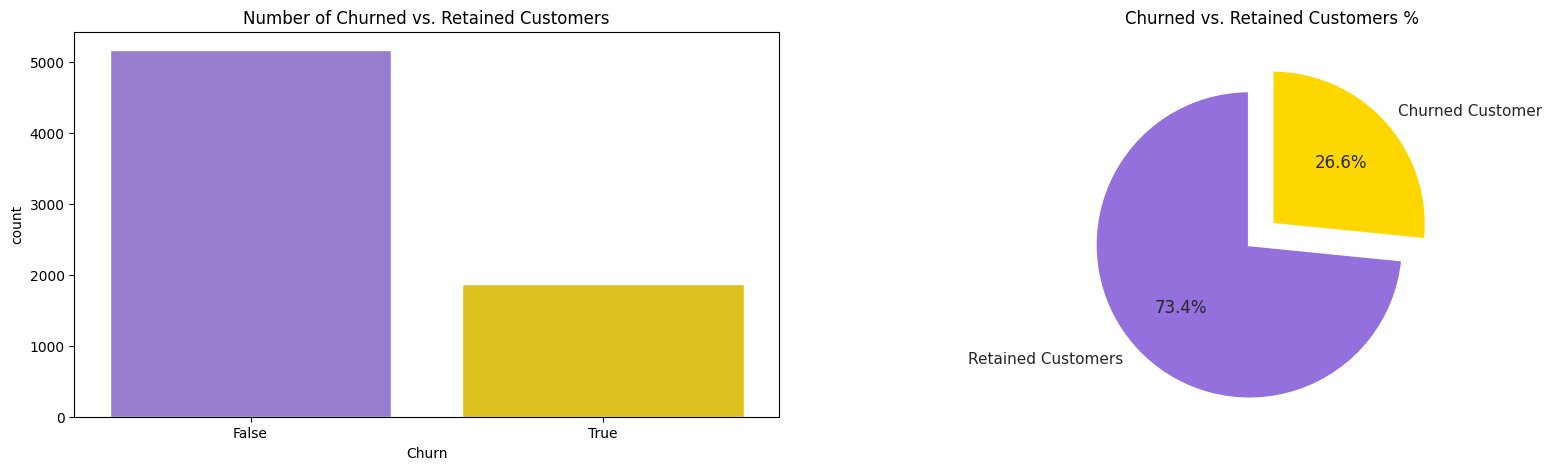

In [ ]:
# Set color palette for the plots
colors = ['#9370DB','#FFD700']

# Calculate the number of occurrences for each unique value in the 'Churn' column
partList = list(cp['Churn'].value_counts())
circle = [partList[0] / sum(partList) * 100, partList[1] / sum(partList) * 100]

# Create a 1x2 grid
fig = plt.subplots(nrows = 1,ncols = 2,figsize = (20,5))
# First subplot
plt.subplot(1,2,1)
sns.set_theme(style="whitegrid")
# Create a count plot using the 'Churn' column
sns.countplot(x=cp["Churn"],palette=colors)
plt.title('Number of Churned vs. Retained Customers');
# Second subplot
plt.subplot(1,2,2)
# Create a pie chart using the calculated percentages from the circle list
plt.pie(circle,
        labels = ['Retained Customers','Churned Customer'],
        autopct = '%1.1f%%', startangle = 90, explode = (0.2,0), colors = colors,
        wedgeprops = {'edgecolor': 'white', 'linewidth': 2, 'antialiased' : True})
plt.title('Churned vs. Retained Customers %');
plt.show()

Inferences:
*  The plots clearly show that the number of Retained Customers is much higher than the number of Churned Customers.
* There is a significant class imbalance between Retained and Churned Customers, with a ratio of approximately 3:1.



**Helper functions to plot grid of subplots**

In [ ]:
# Plots barplots using grid of subplots for categorized fields
def plotCategory(df, group):
  ncols = min(2, len(group))
  nrows = (len(group) + 1) // 2

  # Create a nrows x ncols grid of subplots
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 5 * nrows))
  axes = axes.flatten()  # Flatten axes to loop through them
  for i, col in enumerate(group):
    # Group by the current column and Churn, and calculate the counts
    column_churn_counts = df.groupby([col, 'Churn']).size().reset_index(name='counts')

    # Calculate the total counts for the current column
    column_total_counts = df.groupby(col).size().reset_index(name='total_counts')

    # Merge the two dataframes
    merged_counts = pd.merge(column_churn_counts, column_total_counts, on=col)

    # Calculate the normalized percentage of churn for the current column
    merged_counts['percentage'] = (merged_counts['counts'] / merged_counts['total_counts']) * 100

    # Plot the normalized data
    ax = axes[i]
    barplot = sns.barplot(x=col, y='percentage', hue='Churn', data=merged_counts, palette=colors, edgecolor='black', ax=ax)
    ax.set_title(f'{col} vs. Churn (Normalized)')
    ax.set_xlabel(col)
    ax.set_ylabel('Churn Percentage')
    # Add the percentage text on top of the bars
    for p in barplot.patches:
        barplot.annotate(f'{p.get_height():.1f}%', (p.get_x() + p.get_width() / 2, p.get_height()),
                         ha='center', va='baseline', fontsize=10, color='black', xytext=(0, 5), textcoords='offset points')

  if len(group) % 2 != 0:
    fig.delaxes(axes[-1])
  plt.tight_layout()
  plt.show()

# Plots KDE plot using grid of subplots for numeric data
def plotKDEplot(df, group):
  ncols = min(2, len(group))
  nrows = (len(group) + 1) // 2

  # Filter the data for non-churned and churned customers
  non_churned = cp[cp['Churn'] == 0]
  churned = cp[cp['Churn'] == 1]

  # Create a nrows x ncols grid of subplots
  fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(8 * ncols, 5 * nrows))
  if nrows == 1 and ncols == 1:
    axes = [axes]
  for i, col in enumerate(group):
      # Create a KDE plot for the current column of non-churned and churned customers
      sns.kdeplot(non_churned[col], ax=axes[i], fill=True, label='Retained', color='blue')
      sns.kdeplot(churned[col], ax=axes[i], fill=True, label='Churned', color='red')

      # Find the peak positions for non-churned and churned customers
      non_churned_peak = non_churned[col].value_counts().idxmax()
      churned_peak = churned[col].value_counts().idxmax()
      # Add vertical lines to mark the peak positions
      axes[i].axvline(non_churned_peak, color='blue', linestyle='--', label=f'Retained Peak: {non_churned_peak}')
      axes[i].axvline(churned_peak, color='red', linestyle='--', label=f'Churned Peak: {churned_peak}')

      axes[i].set_title(f'KDE Plot of {col} for Retained and Churned Customers')
      axes[i].set_xlabel(col)
      axes[i].set_ylabel('Density')
      axes[i].legend()
  if len(group) != 1 and len(group) % 2 != 0:
    fig.delaxes(axes[-1])
  plt.tight_layout()
  plt.show()

**Group 1 : Customer Information**

*('gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure')*



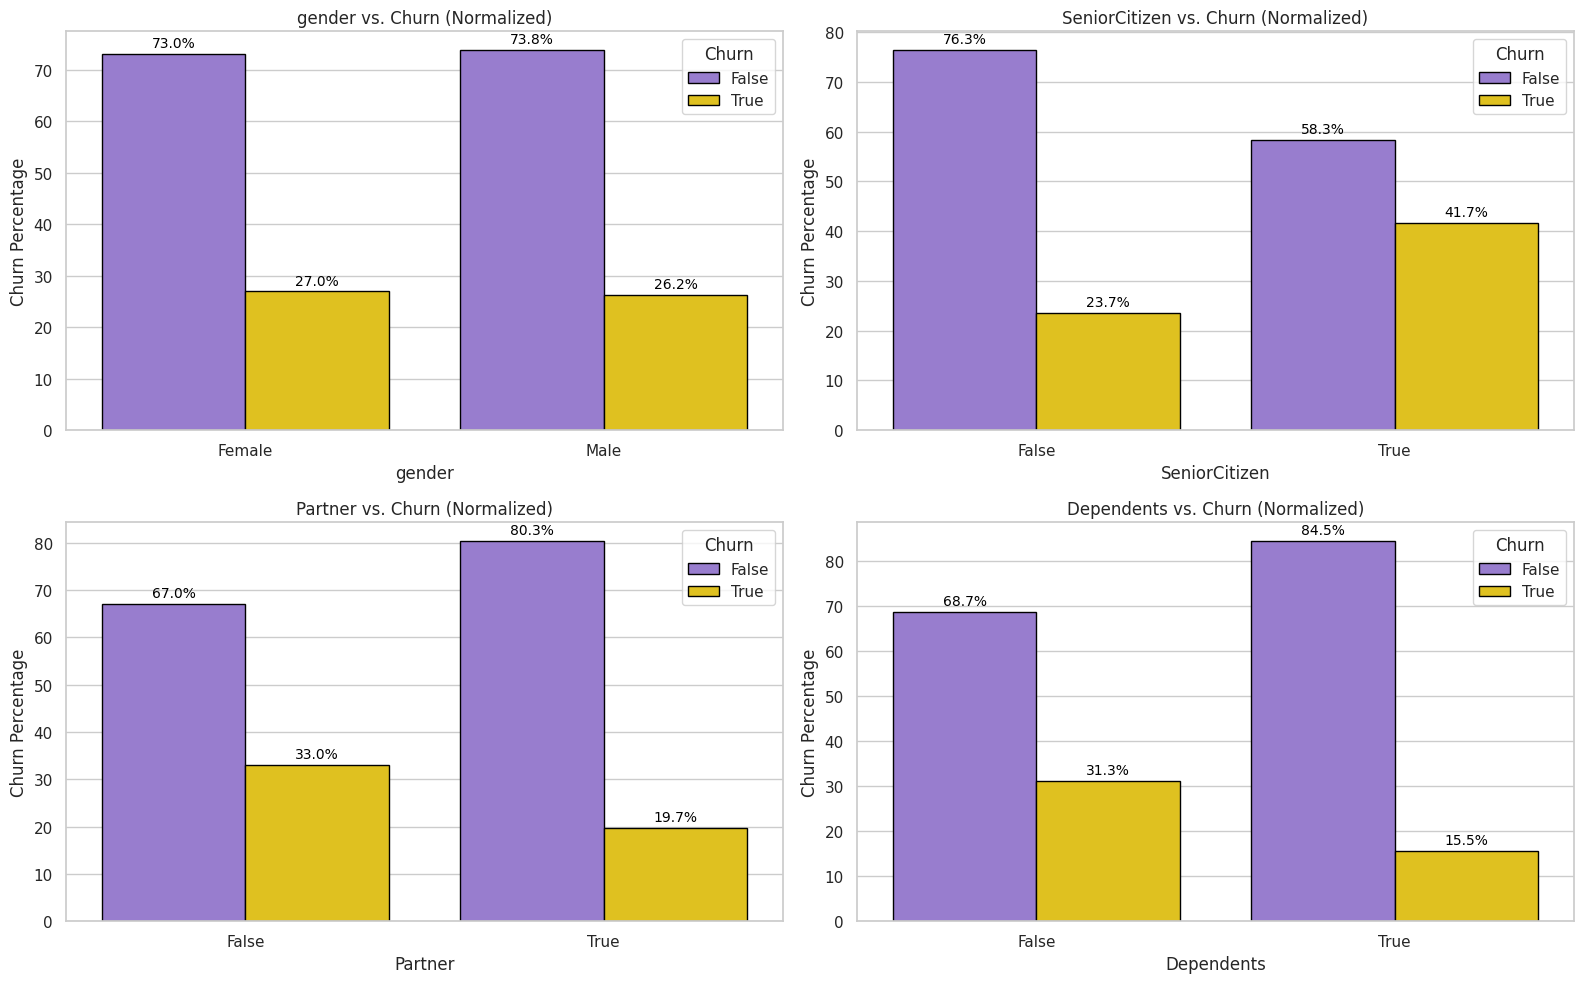

In [ ]:
# Plot g1 categorized items vs Normalized Churn (except tenure)
g1 = [x for x in group1 if x != 'tenure']
plotCategory(cp, g1)

Inferences:
* Gender does not seem to have a significant effect on churn, as the proportion of churned customers is similar between males and females.
* SeniorCitizens churn at a higher rate.
* Customers with a Partner are less likely to churn compared to customers without a Partner.
* Customers who do not have Dependents are more likely to churn than customers with Dependents.


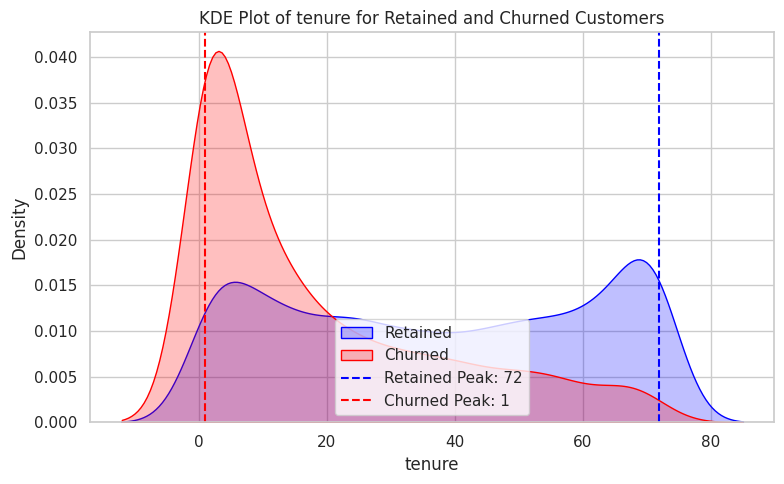

In [ ]:
# KDE plot for tenure
g = ['tenure']
plotKDEplot(cp, g)

Inferences:
* Churned customers tend to have a shorter tenure compared to retained customers.

**Group 2 : Services signed up for**

*('PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies')*



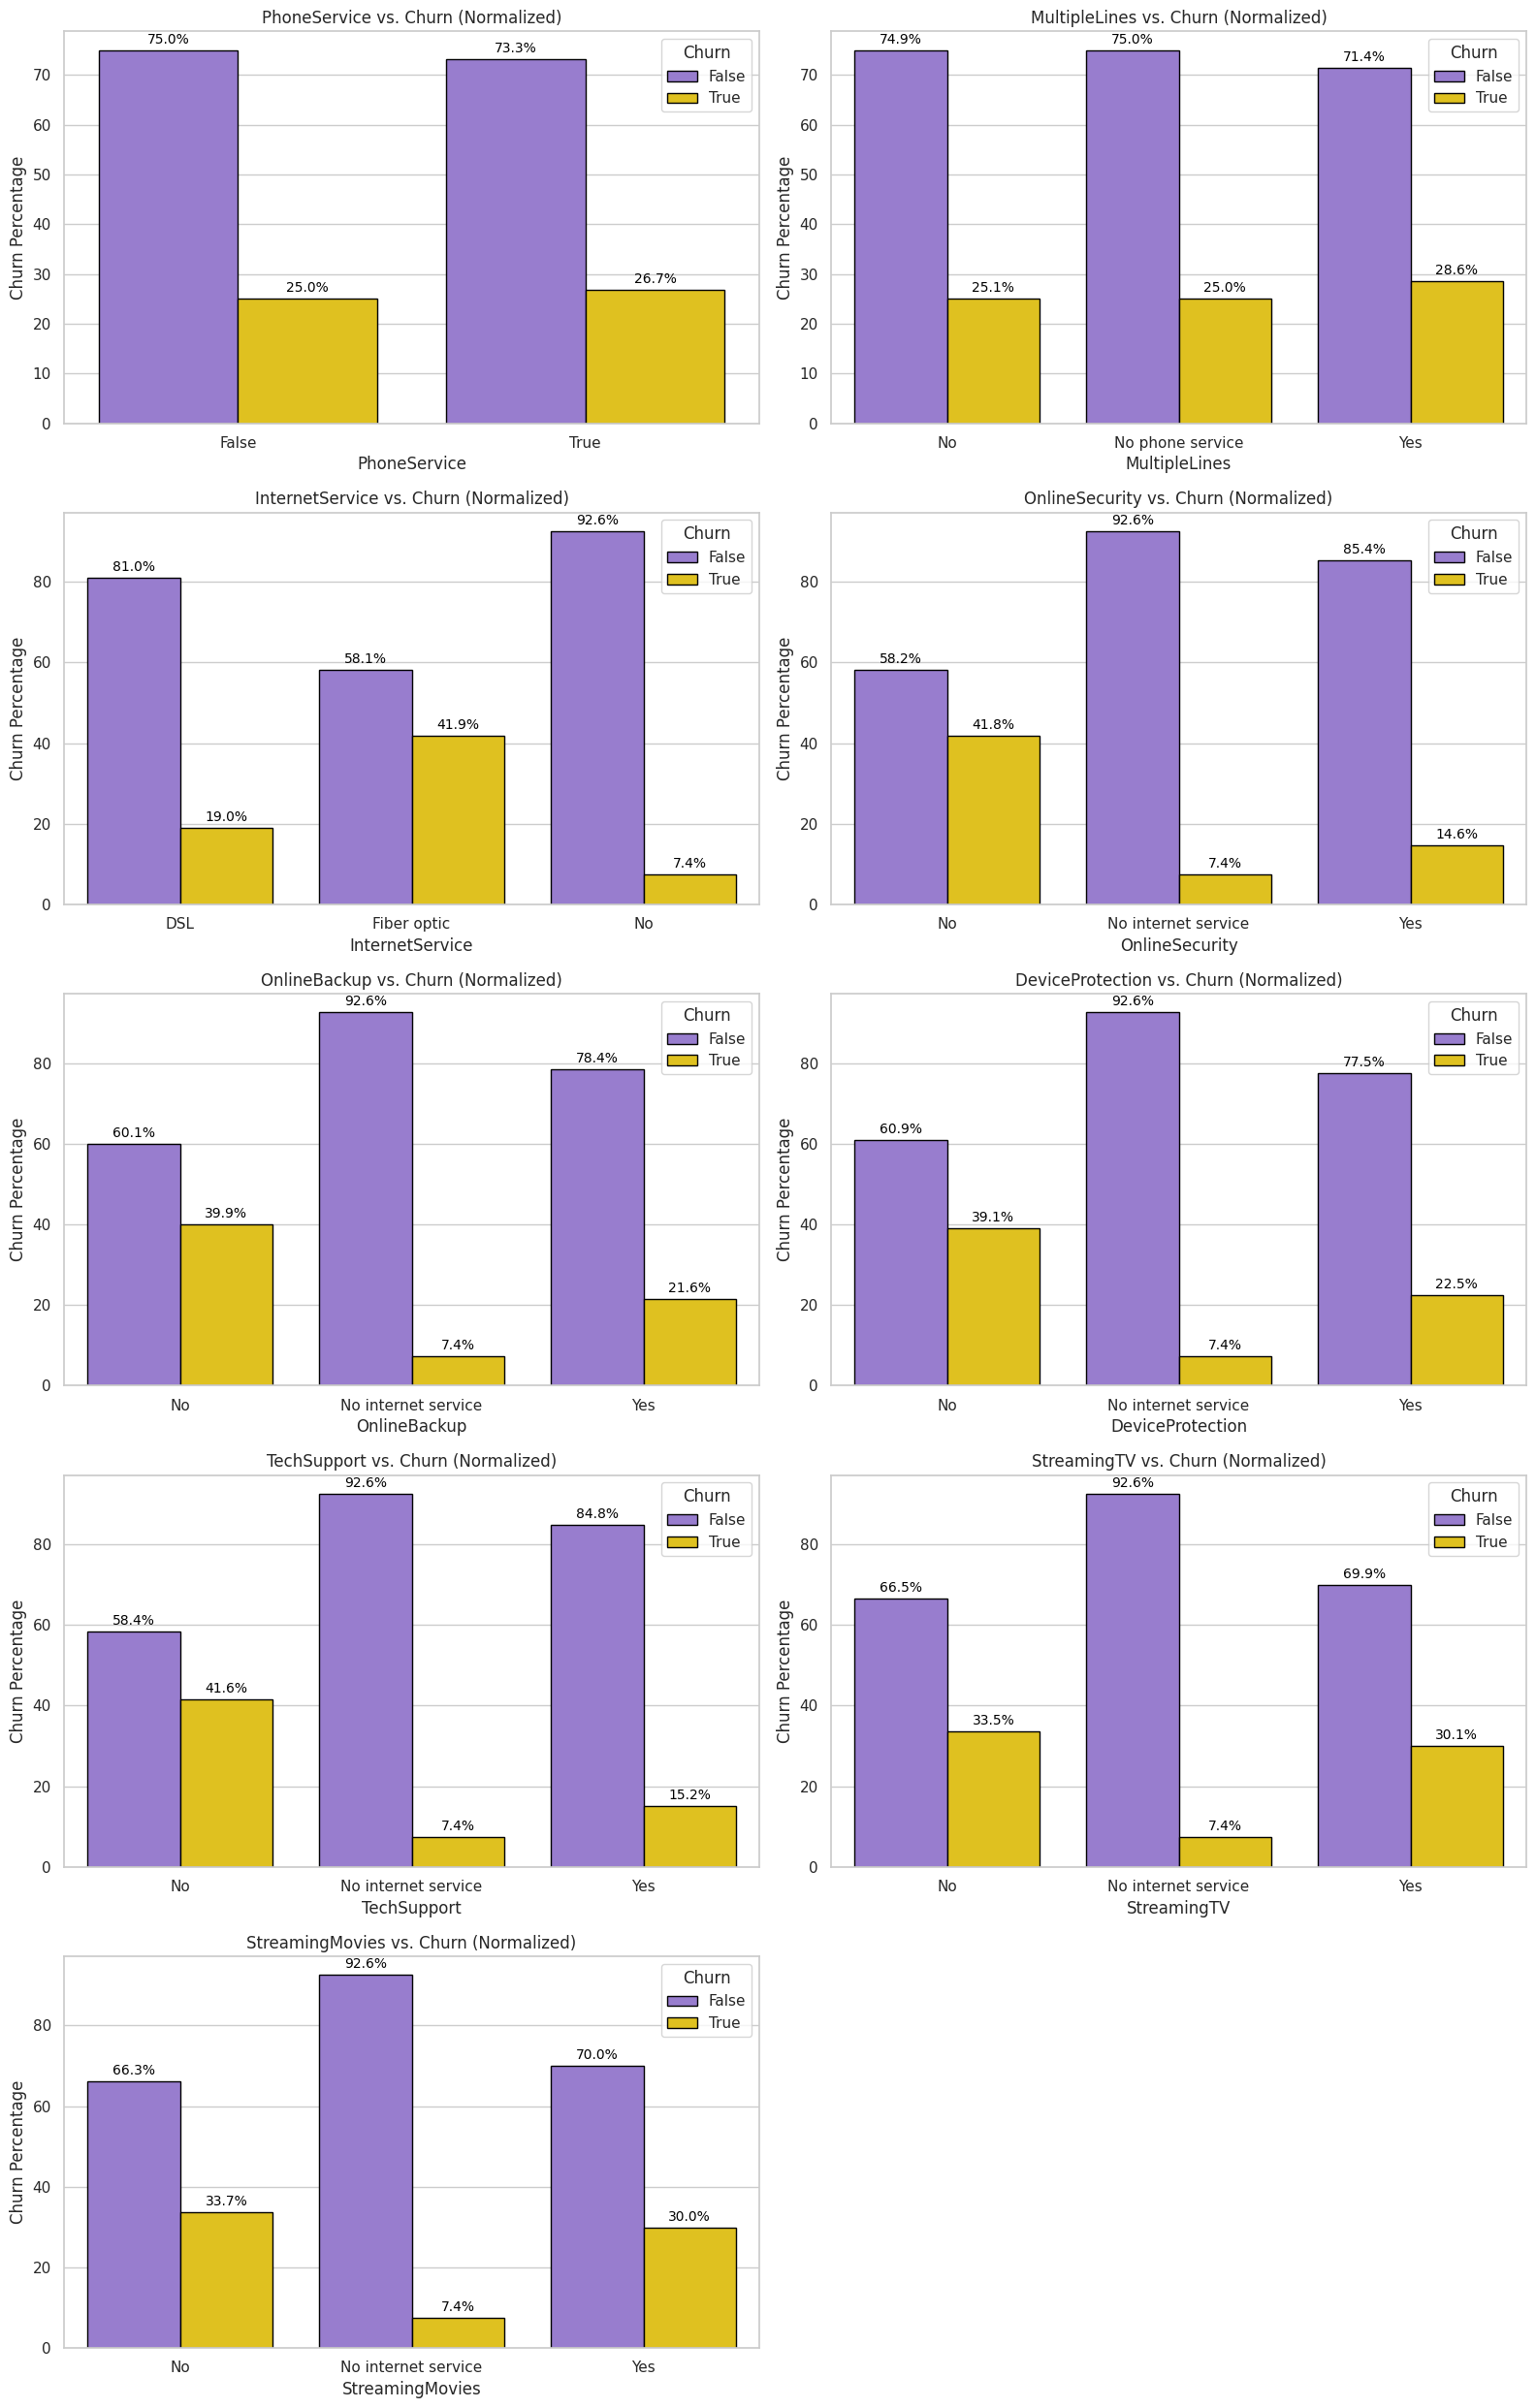

In [ ]:
# Plot group2 categorized items vs Normalized Churn
plotCategory(cp, group2)

Inferences:
* PhoneService does not appear to have a significant impact on customer churn.
* Having MultipleLines appears to only slightly increase the likelihood of customer churn.
* InternetService seems to have a significant impact on customer churn, particularly Fiber optic Internet service, which appears to significantly increase the likelihood of customer churn.
* Not having OnlineSecurity, OnlineBackup, DeviceProtection, and TechSupport appears to significantly increase the likelihood of customer churn.
* Not having StreamingTV or StreamingMovies appears to slightly increase the likelihood of customer churn.


**Group 3 : Payment**

*('Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges')*



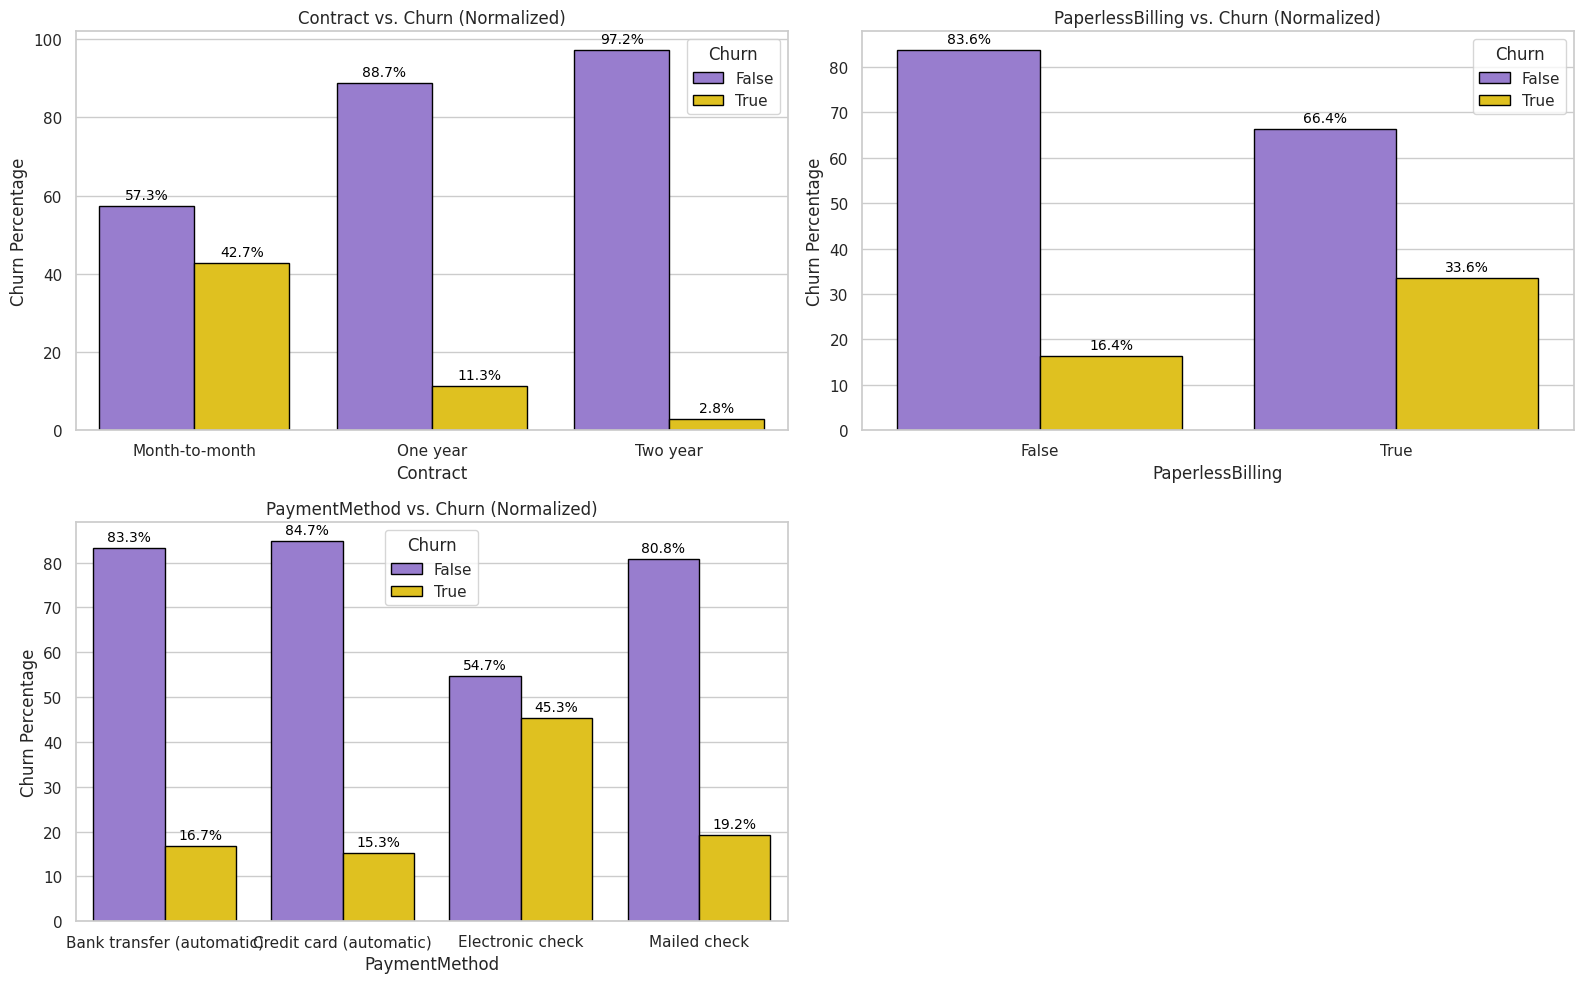

In [ ]:
# Plot g3 categorized items vs Normalized Churn (except 'MonthlyCharges' and 'TotalCharges')
g3 = ['Contract', 'PaperlessBilling', 'PaymentMethod']
plotCategory(cp, g3)

Inferences:
* Customers with a month-to-month contract are more likely to churn compared to customers with one year and two year contracts.
* Not having paperless billing is associated with a lower likelihood of churn.
* Customers who use electronic check as their payment method are more likely to churn compared to customers who use other payment options.


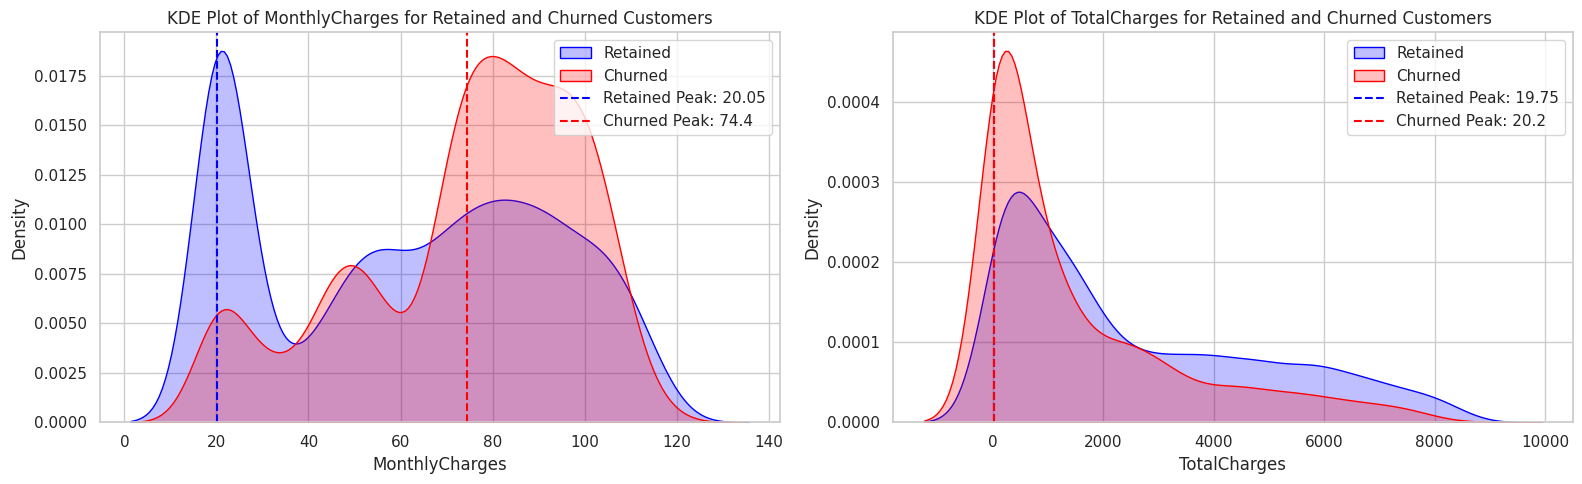

In [ ]:
# KDE plot for MonthlyCharges and TotalCharges
g = ['MonthlyCharges', 'TotalCharges']
plotKDEplot(cp, g)

Inferences:
* Churned customers tend to have higher Monthly Charges compared to Retained Customers.
* Churned customers have less Total Charges than Retained Customers (Possibility: due to less tenure).

Total Monthly Revenue loss

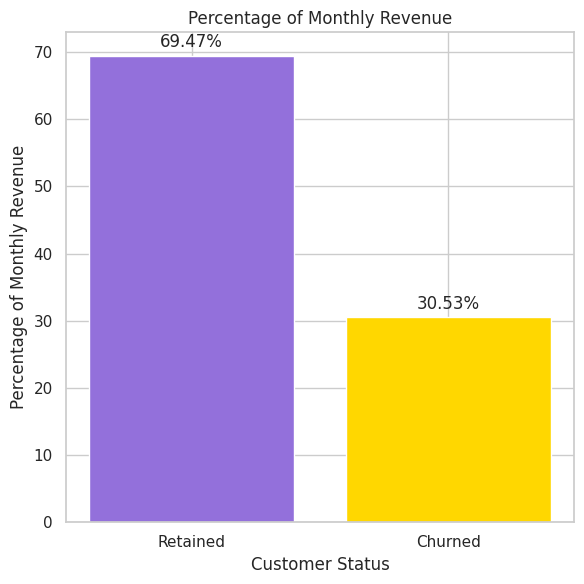

In [ ]:
# Calculate the total amount of monthly charges for each churn group
churn_monthly_charges = cp.groupby('Churn')['MonthlyCharges'].sum()

# Calculate the percentage of monthly revenue lost by churn customers
churn_percentage = (churn_monthly_charges[1] / (churn_monthly_charges[0] + churn_monthly_charges[1])) * 100

# Create a bar chart to visualize the percentage of monthly revenue for each group
fig, ax = plt.subplots(figsize=(6, 6))
bars = ax.bar(['Retained', 'Churned'], [100 - churn_percentage, churn_percentage], color=colors)
ax.set_title('Percentage of Monthly Revenue')
ax.set_xlabel('Customer Status')
ax.set_ylabel('Percentage of Monthly Revenue')
# Add the percentage values at the top of each bar
for bar in bars:
  height = bar.get_height()
  ax.annotate(f'{height:.2f}%', xy=(bar.get_x() + bar.get_width() / 2, height),
              xytext=(0, 3), textcoords="offset points", ha='center', va='bottom')
plt.tight_layout()
plt.show()

Inferences:
* Customers who churned resulted in a reduction of 30% in the total revenue.

**Heatmap of the Correlation Matrix**

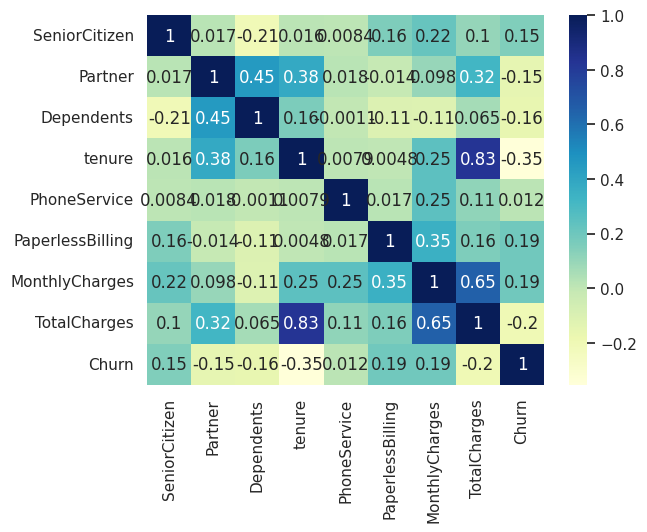

In [ ]:
# Plot a heatmap
corr_matrix = cp.corr(numeric_only=True) # Create a correlation matrix
sns.heatmap(corr_matrix, annot=True, cmap="YlGnBu")
plt.show()

Inferences:
* Senior citizens tend to have slightly higher monthly charges.
* Customers who have a partner are more likely to have dependents.
* Customers who have been with the company for a longer time are more likely to have a partner or dependents.
* Customers who have phone service tend to have higher monthly charges.
* Customers who use paperless billing tend to have higher monthly and total charges.
* Customers who have higher monthly charges tend to accumulate higher total charges over time.
* Customers who have been with the company for a longer time are less likely to churn.
* Customers who have higher total charges are slightly less likely to churn.

Feature selection tips:
* TotalCharges and tenure have high positive correlation, with tenure vs Churn having a higher magnitude of negative correlation compared to TotalCharges vs Churn. Thus, tenure might be a stronger predictor of Churn compared to TotalCharges.


**Few Bivariate Comparisons**




In [ ]:
# Plot heatmap for the cross-tabulation between 2 features
def plotCrossTab(cp, x1, x2):
  # Calculate the cross-tabulation between x1 and x2
  cross_tab = pd.crosstab(cp[x1], cp[x2])
  # Plot the heatmap
  fig, ax = plt.subplots(figsize=(6, 4))
  sns.heatmap(cross_tab, annot=True, fmt='d', cmap='coolwarm', linewidths=0.5, ax=ax)
  plt.title(f"{x1} vs {x2}")
  plt.xlabel(f"{x2}")
  plt.ylabel(f"{x1}")
  plt.show()

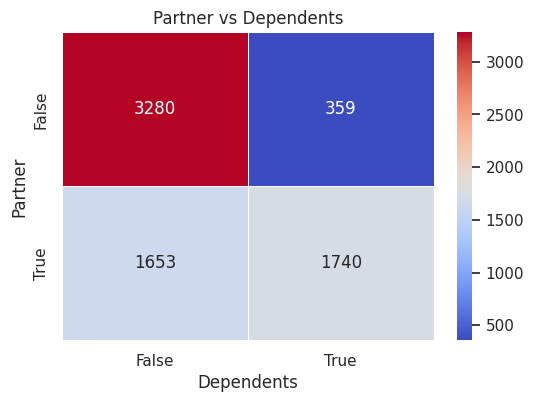

In [ ]:
# Comparison between Partner and Dependents
plotCrossTab(cp, 'Partner', 'Dependents')

Inferences:
* Customers with no partner are less likely to have dependents.
* Customers with a partner are more likely to have dependents.



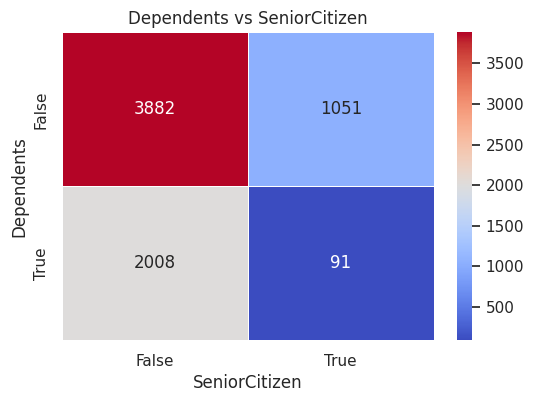

In [ ]:
# Comparison between Dependents and SeniorCitizen
plotCrossTab(cp, 'Dependents', 'SeniorCitizen')

Inferences:
* Senior citizens mostly do not have dependents.
* Non-senior citizens tend to have a higher proportion of customers without dependents compared to those with dependents.


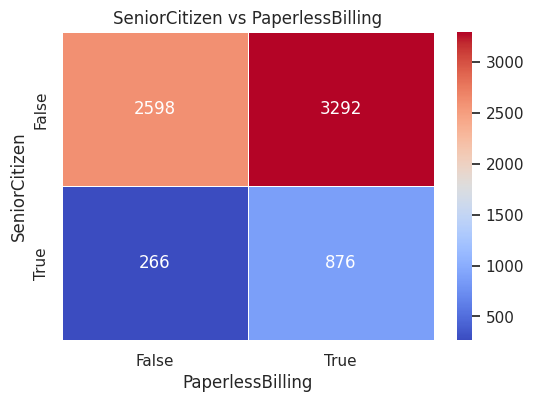

In [ ]:
# Comparison between SeniorCitizen and PaperlessBilling
plotCrossTab(cp, 'SeniorCitizen', 'PaperlessBilling')

Inferences:
* Majority of non-senior customers use paperless billing.
* Among senior citizens, there are still more customers who use paperless billing than those who do not.



# Feature Selection

**Chi-square test results for categorical features**


In [ ]:
# Select the categorical columns
categorical_columns = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
                       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
chi2_results = []
# Perform Chi-square test for each categorical feature against 'Churn'
for col in categorical_columns:
  cross_tab = pd.crosstab(cp[col], cp['Churn'])
  chi2, p_value, _, _ = chi2_contingency(cross_tab)
  chi2_results.append([col, chi2, p_value])

# Create a DataFrame to display the results in a tabular format
chi2_results_df = pd.DataFrame(chi2_results, columns=['Feature', 'Chi2', 'P-value'])
# sort the results by p-value
chi2_results_df.sort_values('P-value', inplace=True)
print(chi2_results_df)

             Feature         Chi2        P-value
13          Contract  1179.545829  7.326182e-257
7     OnlineSecurity   846.677389  1.400687e-184
10       TechSupport   824.925564  7.407808e-180
6    InternetService   728.695614  5.831199e-159
15     PaymentMethod   645.429900  1.426310e-139
8       OnlineBackup   599.175185  7.776099e-131
9   DeviceProtection   555.880327  1.959389e-121
12   StreamingMovies   374.268432   5.353560e-82
11       StreamingTV   372.456502   1.324641e-81
14  PaperlessBilling   256.874908   8.236203e-58
3         Dependents   186.321639   2.019659e-42
1      SeniorCitizen   158.440816   2.479256e-36
2            Partner   157.503151   3.973798e-36
5      MultipleLines    11.271541   3.567927e-03
4       PhoneService     0.873733   3.499240e-01
0             gender     0.475455   4.904885e-01


Inference:
* Gender and PhoneService do not significantly affect Churn, as indicated by their P-values (> 0.05). Therefore, these features can be dropped from the analysis.

In [ ]:
# # Drop the fields gender and PhoneService
cp = cp.drop('gender', axis=1)
cp = cp.drop('PhoneService', axis=1)

# Data Preprocessing


To tackle class imbalance, we take the following steps:

* One-hot encode categorical features, dropping the first category of each feature to avoid multicollinearity.
* Split the dataset into training and testing sets (80:20 ratio) for evaluating model performance on unseen data.
* Apply Synthetic Minority Over-sampling Technique (SMOTE) to oversample the minority class (churning customers) and balance the target variable ('Churn') in the training set.
* Apply Edited Nearest Neighbor (ENN) technique to remove noisy samples from the majority class (non-churning customers).

In [ ]:
# One-hot encode the categorical features
cp_encoded = pd.get_dummies(cp, drop_first=True)
X = cp_encoded.drop(columns='Churn')
y = cp_encoded['Churn']

# Split the dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Apply SMOTE to the training set
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Apply ENN to the SMOTE output
enn = EditedNearestNeighbours(sampling_strategy='majority')
X_train_smote_enn, y_train_smote_enn = enn.fit_resample(X_train_smote, y_train_smote)

# Create a DataFrame from the SMOTE-ENN output
X_train_smote_enn_df = pd.DataFrame(X_train_smote_enn, columns=X_train.columns)
y_train_smote_enn_df = pd.Series(y_train_smote_enn)

# Display the counts of the target variable before and after SMOTE and ENN
print("Before SMOTE:\n", y_train.value_counts())
print("\nAfter SMOTE:\n", y_train_smote.value_counts())
print("\nAfter SMOTE and ENN:\n", y_train_smote_enn_df.value_counts())

Before SMOTE:
 False    4130
True     1495
Name: Churn, dtype: int64

After SMOTE:
 True     4130
False    4130
Name: Churn, dtype: int64

After SMOTE and ENN:
 True     4130
False    2131
Name: Churn, dtype: int64


# Feature Scaling

* Continuous features such as tenure, MonthlyCharges, and TotalCharges are scaled using standard scaling to ensure that they contribute equally to the model. This helps the model converge faster and avoids any one feature from dominating the other features.
* We apply standard scaling to these features, transforming them to have a mean of 0 and a standard deviation of 1.

In [ ]:
# Define the numeric features
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Instantiate the standard scaler
scaler = StandardScaler()

# Fit the scaler on the numeric features of the training set (SMOTE-ENN output)
X_train_smote_enn_df[numeric_features] = scaler.fit_transform(X_train_smote_enn_df[numeric_features])

# Transform the numeric features of the test set using the same scaler
X_test[numeric_features] = scaler.transform(X_test[numeric_features])

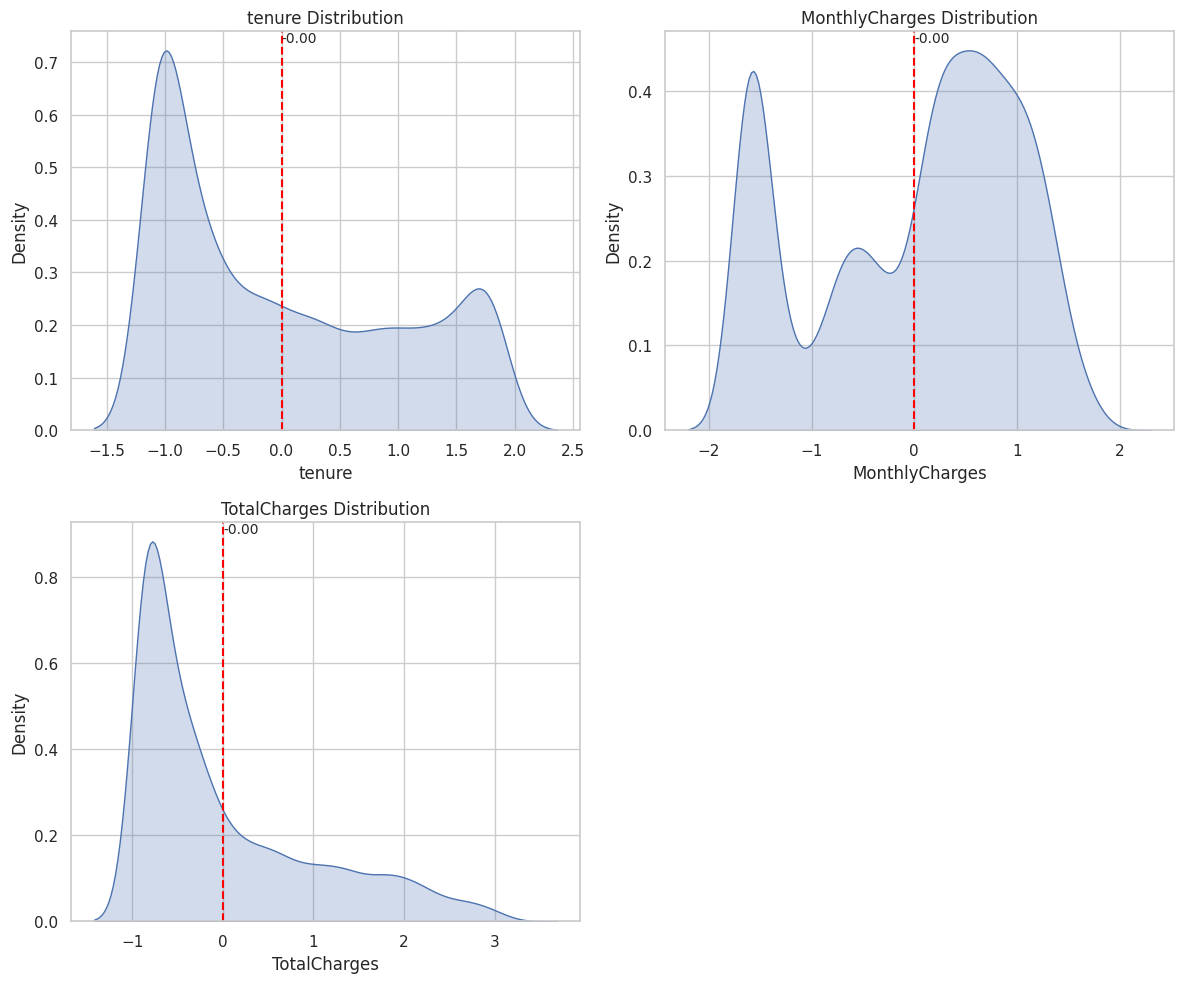

In [ ]:
# Plot the distribution of the numeric features
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))
axes = axes.ravel()
numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
for i, feature in enumerate(numeric_features):
    sns.kdeplot(X_train_smote_enn_df[feature], ax=axes[i], fill=True)
    axes[i].set_title(f'{feature} Distribution')
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel('Density')
    # Get peak value and plot it on x-axis
    peak_val = X_train_smote_enn_df[feature].mean()
    axes[i].axvline(x=peak_val, color='red', linestyle='--')
    axes[i].text(peak_val, axes[i].get_ylim()[1], f'{peak_val:.2f}', fontsize=10, va='top')
fig.delaxes(axes[-1])
plt.tight_layout()
plt.show()

# Machine Learning Models using sklearn

Helper functions

In [ ]:
modelDict = {}

def getEvalMetrics(modelName, conf_matrices):
  # Calculate the average confusion matrix
  avg_conf_matrix = np.mean(conf_matrices, axis=0)

  # Calculate the sum of all elements in the confusion matrix
  total = np.sum(avg_conf_matrix)

  # Calculate the true positives, true negatives, false positives, and false negatives
  tp = avg_conf_matrix[1, 1]
  tn = avg_conf_matrix[0, 0]
  fp = avg_conf_matrix[0, 1]
  fn = avg_conf_matrix[1, 0]

  # Calculate the accuracy, true positive rate, and false positive rate
  accuracy = (tp + tn) / total
  tpr = tp / (tp + fn)
  fpr = fp / (fp + tn)
  # Calculate the precision, recall and F1 score
  precision = tp / (tp + fp)
  recall = tp / (tp + fn)
  f1_score = 2 * precision * recall / (precision + recall)

  # Store metrics
  modelDict[modelName] = {}
  modelDict[modelName]['Accuracy'] = accuracy
  modelDict[modelName]['True Positive Rate'] = tpr
  modelDict[modelName]['False Positive Rate'] = fpr
  modelDict[modelName]['F1 Score'] = f1_score

  # Print the results
  print("\nAccuracy:", accuracy)
  print("True Positive Rate:", tpr)
  print("False Positive Rate:", fpr)
  print("F1 Score:", f1_score)

# Plot confusion matrix
def plot_conf_matrix(conf_matrix, classes, title, cmap=plt.cm.Blues):
  fig, ax = plt.subplots()
  im = ax.imshow(conf_matrix, interpolation='nearest', cmap=cmap)
  ax.figure.colorbar(im, ax=ax)
  ax.set(xticks=np.arange(conf_matrix.shape[1]),
          yticks=np.arange(conf_matrix.shape[0]),
          xticklabels=classes, yticklabels=classes,
          title=title,
          ylabel='True label',
          xlabel='Predicted label')
  ax.set_xticks([], [])
  ax.set_yticks([], [])
  fmt = '.2f'
  thresh = conf_matrix.max() / 2.
  for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
      ax.text(j, i, format(conf_matrix[i, j], fmt),
              ha="center", va="center",
              color="white" if conf_matrix[i, j] > thresh else "black")
  fig.tight_layout()
  plt.show()

def trainTestAndPlot(modelName, model):
  conf_matrices = []
  # Define the cross-validation method
  cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=39)

  # Perform cross-validation
  for train_index, test_index in cv.split(X, y):
    # Split the data into training and test sets
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    # Apply SMOTE and ENN to the training set
    X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)
    X_train_smote_enn, y_train_smote_enn = enn.fit_resample(X_train_smote, y_train_smote)

    # Create a DataFrame from the SMOTE-ENN output
    X_train_smote_enn_df = pd.DataFrame(X_train_smote_enn, columns=X_train.columns)
    y_train_smote_enn_df = pd.Series(y_train_smote_enn)

    # Fit the model to the training data
    model.fit(X_train_smote_enn_df, y_train_smote_enn_df)

    # Predict on the test data
    y_pred = model.predict(X_test)

    # Append the confusion matrix to the list
    conf_matrices.append(confusion_matrix(y_test, y_pred))

  # Print details
  getEvalMetrics(modelName, conf_matrices)

  # Calculate the average confusion matrix
  avg_conf_matrix = np.mean(conf_matrices, axis=0)
  # Plot the confusion matrix
  plot_conf_matrix(avg_conf_matrix, classes=['0', '1'], title=f"{modelName} - Confusion Matrix")

  # Plot the ROC curve
  fpr, tpr = 0, 0
  if modelName == 'Stochastic Gradient Descent Classifier':
    # Use decision_function instead of predict_proba
    y_score = model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_score)
  else:
    y_pred_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
  roc_auc = auc(fpr, tpr)
  print(f"\nArea under ROC Curve: {roc_auc}\n")
  # modelDict[modelName]['Area under ROC Curve'] = roc_auc
  plt.figure()
  lw = 2
  plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'{modelName} - ROC Curve')
  plt.legend(loc="lower right")
  plt.show()

# **1. Logistic Regression**


Accuracy: 0.6943970420932878
True Positive Rate: 0.8657035848047084
False Positive Rate: 0.36761572729033515
F1 Score: 0.6009285051067782


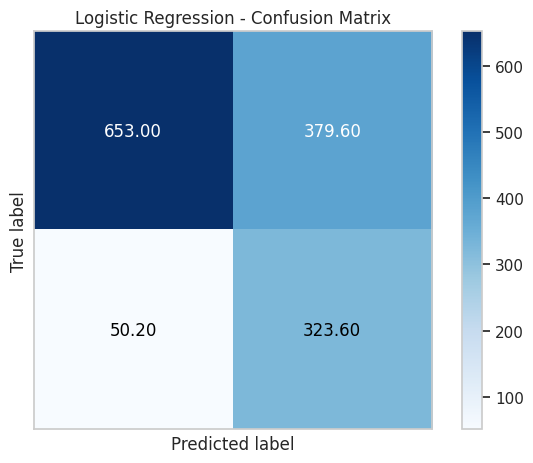


Area under ROC Curve: 0.8284559859884757



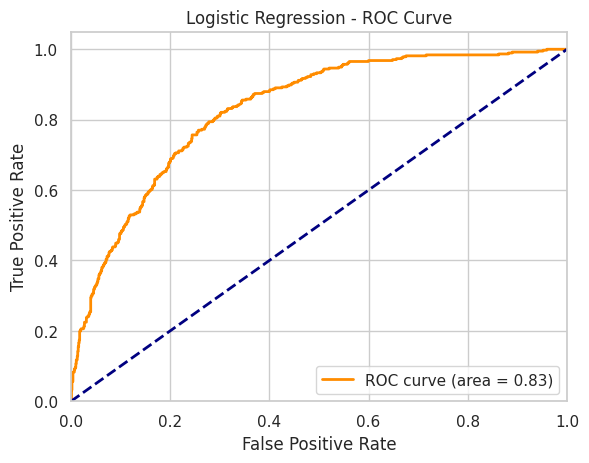

In [ ]:
# Create a logistic regression object
logreg = LogisticRegression(random_state=39)

# Train and test the model, and print evaluation metrics
trainTestAndPlot('Logistic Regression', logreg)


**Why was this algorithm chosen ?**

Logistic Regression is a common and popular algorithm for binary classification problems like churn prediction. It's useful when the relationship between the input features and the output variable is linear and in our case, many features including SeniorCitizens, Partner, Dependents, InternetService, OnlineSecurity, OnlineBackup, DeviceProtection, TechSupport have a linear relationship with Churn.

**How does this algorithm perform for our dataset?**

It performs reasonably well, the true positive rate (sensitivity) of 0.865 indicates the model is able to correctly identify a large proportion of customers who are likely to churn, and the false positive rate of 0.367 indicates that the model has a relatively high rate of false positives.

**Why was the performance moderate?**
Logistic Regression does not perform well in datasets (eg. telco customer churn) with non linear data. Logistic regression also assumes that features are independent of each other but in reality, features are correlated.

# **2. Stochastic Gradient Descent Classifier**


Accuracy: 0.6653868031854381
True Positive Rate: 0.7549491706795078
False Positive Rate: 0.36703466976564014
F1 Score: 0.5453140096618357


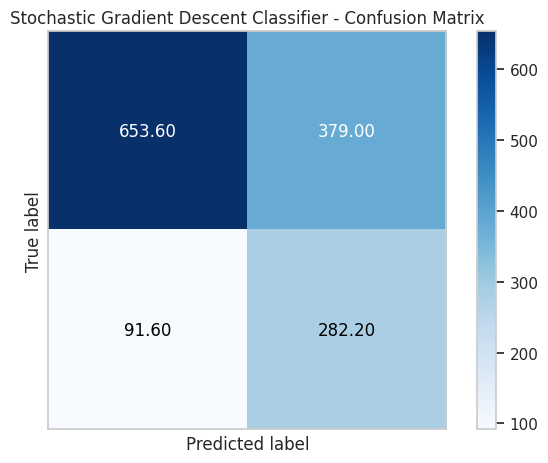


Area under ROC Curve: 0.7763195394436844



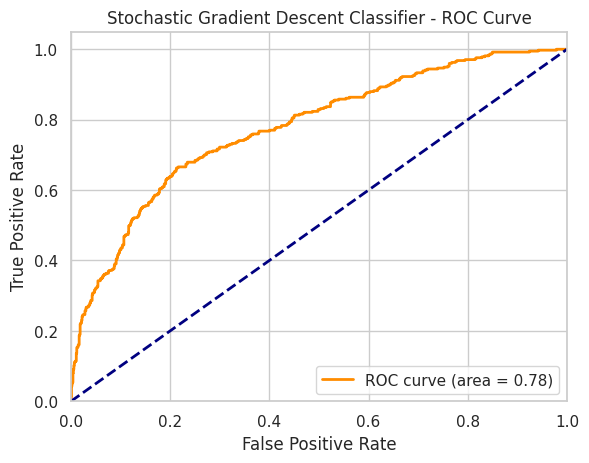

In [ ]:
# Define the SGDClassifier model
sgd_model = SGDClassifier(random_state=39)

# Train and test the model, and print evaluation metrics
trainTestAndPlot('Stochastic Gradient Descent Classifier', sgd_model)

**Why was this algorithm chosen?**

SGC classifier is widely used for classification problems. Our dataset contains many records and columns so we need a fast and computationally efficient algorithm like Stochastic Gradient Descent algorithm which can handle large datasets.

**How does this algorithm perform on our dataset?**

The evaluation metrics value suggest that the SGD classifier has moderate performance in predicting churn. The TPR 0.75 is relatively high, indicating that the classifier is good at identifying customers who are likely to churn, and the FPR 0.37 is relatively high. The F1 score indicates that the classifier's precision and recall are not well-balanced. The area of 0.78 suggests that the classifier is able to correctly classify around 78% of the samples as either positive or negative.

**Why was the performance moderate ?**
SGD is a linear model and may not be able to capture the non-linear relationships and the feature interactions effectively, leading to poor performance.

# **3. XGBoost**


Accuracy: 0.7002275312855518
True Positive Rate: 0.8346709470304976
False Positive Rate: 0.34844082897540196
F1 Score: 0.5967865340474369


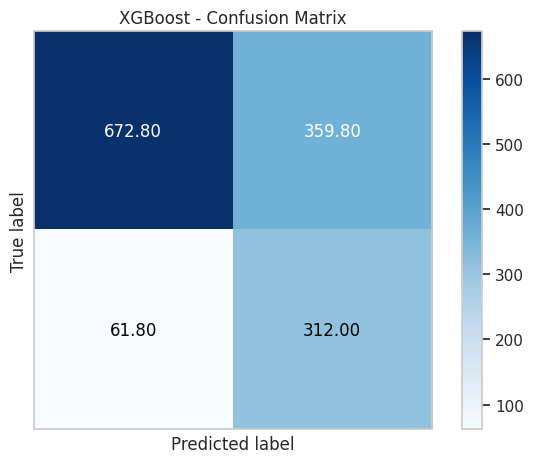


Area under ROC Curve: 0.8093624341914356



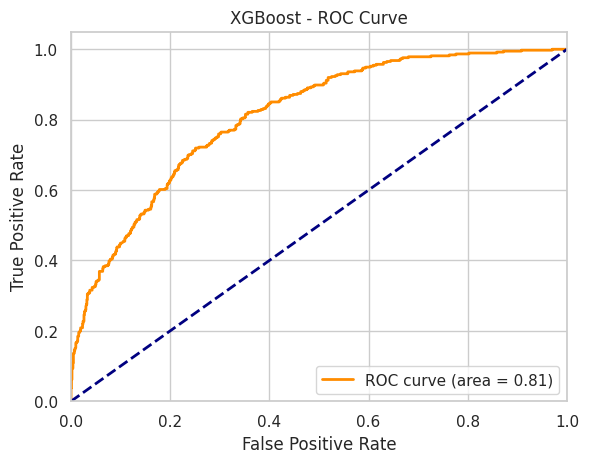

In [ ]:
# Define the XGBoost model
xgb_model = xgb.XGBClassifier(random_state=39)

# Train and test the model, and print evaluation metrics
trainTestAndPlot('XGBoost', xgb_model)

**Why was this algorithm chosen ?**
XGBoost has built-in mechanisms to handle imbalanced data, such as weighted and subsample options, which can help to improve the model's performance. XGBoost is good at feature selection which is helpful for datasets with a large number of variables. This will improve the models' accuracy and reduce the chances of overfitting.

**How does this algorithm perform on our dataset?**
 An accuracy of 0.7 means that the model is correct 70% of the time. The high TPR of 0.83 indicates that the model is good at correctly identifying customer churns which is an important component in our project. FPR of 0.35 indicates that it can be reduced so that the company does not unnecessarily offer incentives to customers who are unlikely to churn. An F1 score of 0.6 suggests that the model's precision and recall are moderate, and there is room for improvement.

**Why was the performance moderate?**
The data available is insufficient for the model to accurately learn and make accurate predictions since there are some complex relationships in telco customer churn dataset that the XGBoost classifier is unable to learn.

# **4. K-Nearest Neighbors (KNN)**


Accuracy: 0.6171786120591582
True Positive Rate: 0.8352059925093632
False Positive Rate: 0.4617470462909162
F1 Score: 0.5369797041623666


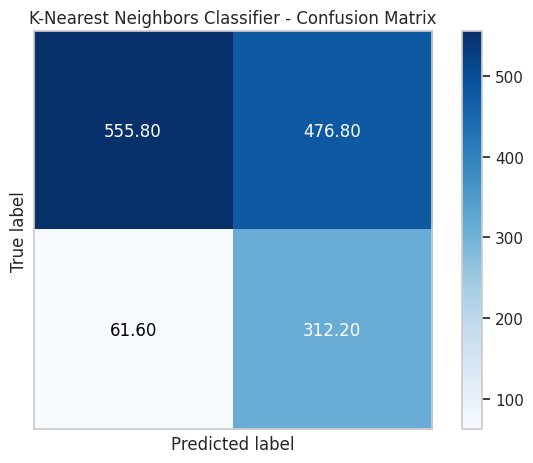


Area under ROC Curve: 0.7148688492310245



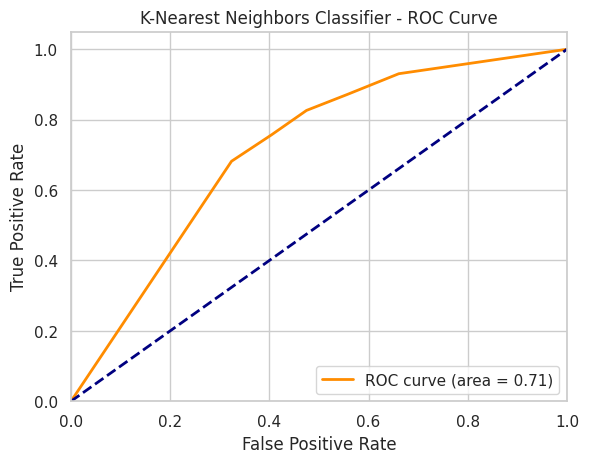

In [ ]:
# Define the kNN model
knn_model = KNeighborsClassifier()

# Train and test the model, and print evaluation metrics
trainTestAndPlot('K-Nearest Neighbors Classifier', knn_model)

**Why was this algorithm chosen ?**

Knn algorithm is simple and fast and our dataset contains many records and features to be considered. It can also capture complex and nonlinear relationships between the features and the target variable.

**How does this algorithm perform on our dataset?**

Although the TPR is quite high, the accuracy is low because of high FPR. A high FPR can be costly for a telco company. 0.537 F1 score indicates that the model has moderate performance in terms of precision and recall.

**Why was the performance moderate?**
Knn becomes slow and computationally expensive as the dimensionality increases and it is sensitive to the distance metric, if a wrong metric is used, the performance of KNN will be affected.

# **5. Support Vector Machines (SVM)**


Accuracy: 0.4691410693970421
True Positive Rate: 0.8833600856072765
False Positive Rate: 0.6808057331009104
F1 Score: 0.4693674484719261


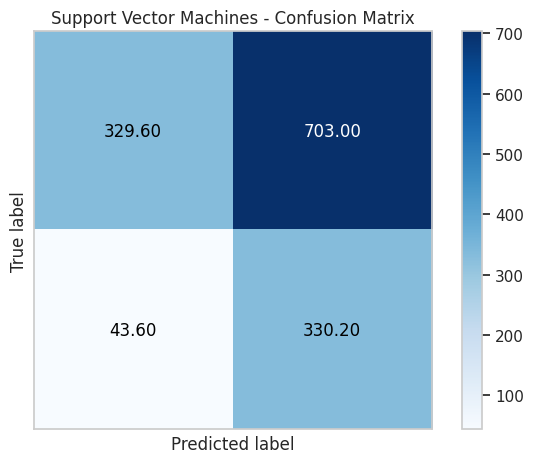


Area under ROC Curve: 0.7533642685403971



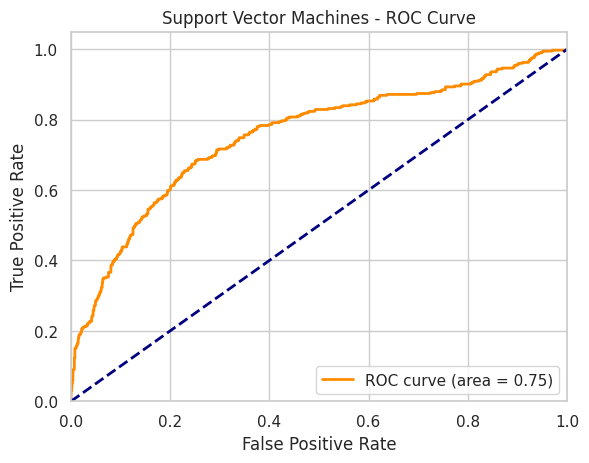

In [ ]:
# Define the SVM model
svm_model = SVC(probability=True, random_state=39)

# Train and test the model, and print evaluation metrics
trainTestAndPlot('Support Vector Machines', svm_model)

**Why was this algorithm chosen ?**

SVM is a commonly used ML algorithm for classification tasks.It models non linear decision boundaries and can handle high dimensional data without overfitting.

**How does this algorithm perform on our dataset?**
The performance of SVM is not good. The accuracy is too low. Although the TPR is high which can be a good thing, the FPR is also high which can cause unnecessary costs to the company.


**Why was the performance moderate?**
We did not choose appropriate model parameters such as the kernel function, regularization parameter, and gamma value that is specific to our dataset, this is the reason why we did not get accurate results. Addressing this issue can improve the model performance.

# **6. Random Forest**


Accuracy: 0.7070534698521046
True Positive Rate: 0.8443017656500803
False Positive Rate: 0.3426302537284525
F1 Score: 0.6050613496932514


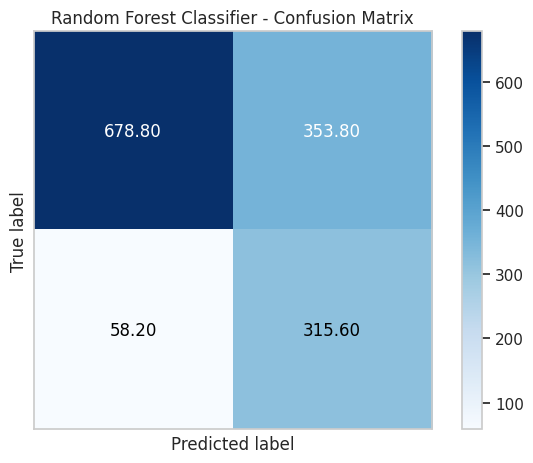


Area under ROC Curve: 0.8241849065207478



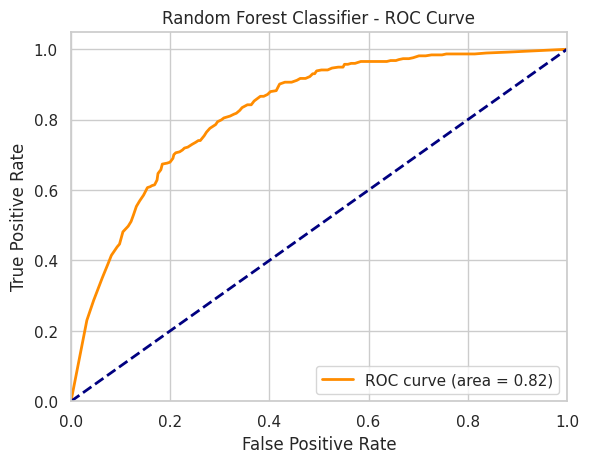

In [ ]:
# Define the Random Forest model
rf_model = RandomForestClassifier(random_state=39)

# Train and test the model, and print evaluation metrics
trainTestAndPlot('Random Forest Classifier', rf_model)

**Why was this algorithm chosen ?**

Random forests can capture non linear relationships that are present in the customer churn dataset and it also provides feature importance rankings.

**How does this algorithm perform on our dataset?**
The model exhibits a not so bad accuracy with a high TPR of 0.84 and this indicates that the model effectively predicts the customers who will churn. The FPR is comparable to other models we have used. F1 score is relatively better than the above models.

**Why was the performance moderate?**
The hyperparameters like number of trees, maximum depth of each tree, number of fetures at each split has not been provides that is specific to our dataset and these hyperparamters play a big role in the performance of Random forests.

# **7. Decision Tree**


Accuracy: 0.685722411831627
True Positive Rate: 0.8031032637774211
False Positive Rate: 0.35676932016269614
F1 Score: 0.5759785111281658


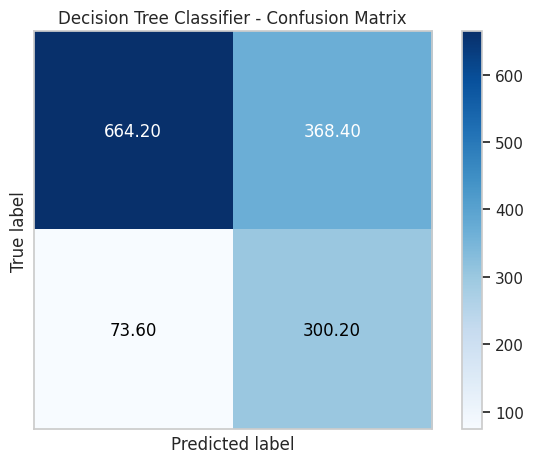


Area under ROC Curve: 0.7082400613522365



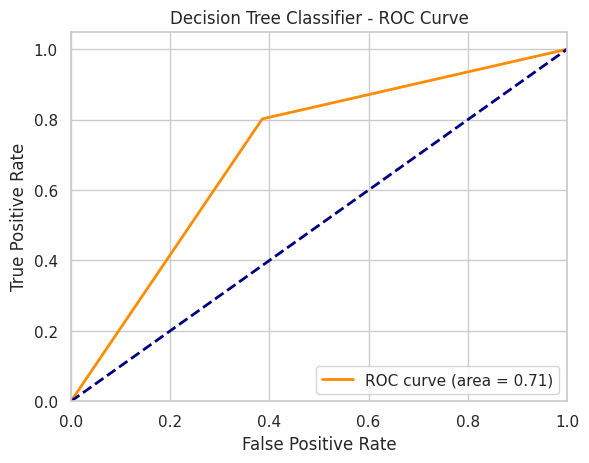

In [ ]:
# Define the Decision Tree model
tree_model = DecisionTreeClassifier(random_state=39)

# Train and test the model, and print evaluation metrics
trainTestAndPlot('Decision Tree Classifier', tree_model)

**Why was this algorithm chosen ?**

Decision trees can handle both categorical and numerical data and it can capture non linear data in the telco customer churn dataset.

**How does this algorithm perform on our dataset?**
An accuracy of 69% indicates that the decision tree algorithm correctly predicts 69% of the time, if the customer will churn or not. The TPR is high and the FPR value is similar to other model's outputs.

**Why was the performance moderate?**
Since we have many features in the dataset and decision trees suffer from curse of dimensionality, the tree struggles to find meaningful splits.

# **8. Naive Bayes**


Accuracy: 0.6858646188850966
True Positive Rate: 0.8523274478330658
False Positive Rate: 0.3743947317451095
F1 Score: 0.5905468025949955


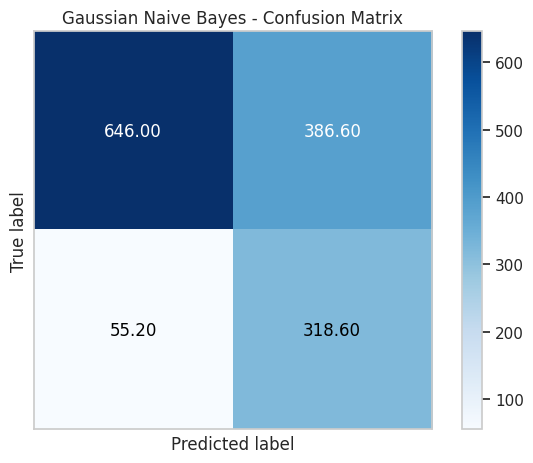


Area under ROC Curve: 0.8067909774903619



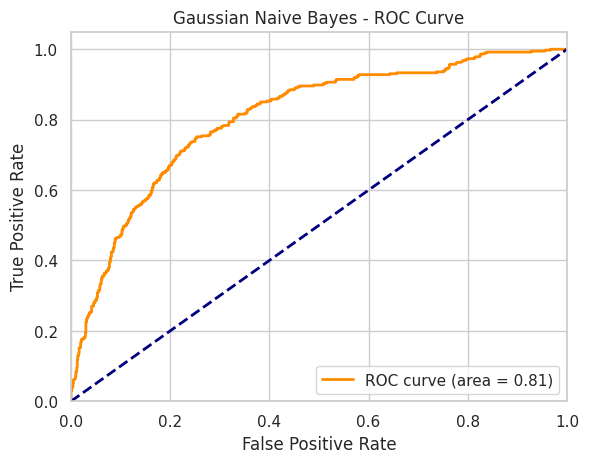

In [ ]:
# Define the Naive Bayes model
nb_model = GaussianNB()

# Train and test the model, and print evaluation metrics
trainTestAndPlot('Gaussian Naive Bayes', nb_model)

**Why was this algorithm chosen ?**

Naive Bayes algorithm is a simple and efficient classification algorithm since it requires minimal computation. The algorithm depends on very less hyperparamters.

**How does this algorithm perform on our dataset?**
An accuracy of 0.68 indicates that the decision tree algorithm correctly predicts if the customer will churn or not by 68%. The TPR is high and the FPR value is similar to other model's outputs.

**Why was the performance moderate?**
Naive Bayes assumes that the features are conditionally independent of each other given the class label. But in telco customer churn dataset, the features are highly correlated. It also assumes that the features are normally distributed. However, in the Telco customer churn dataset, some features are not normally distributed, which can lead to suboptimal performance.

# **9. Kernel SVM**


Accuracy: 0.4691410693970421
True Positive Rate: 0.8833600856072765
False Positive Rate: 0.6808057331009104
F1 Score: 0.4693674484719261


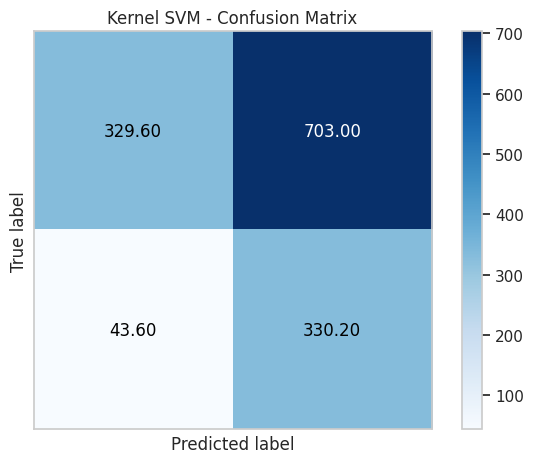


Area under ROC Curve: 0.7533642685403971



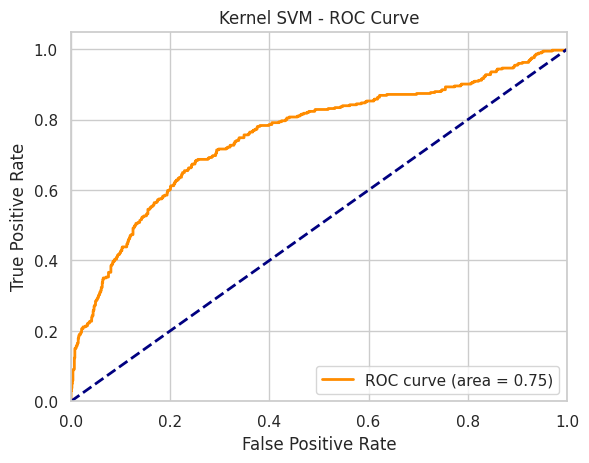

In [ ]:
# Define the SVM model
ksvm_model = SVC(kernel='rbf', probability=True, random_state=39)

# Train and test the model, and print evaluation metrics
trainTestAndPlot('Kernel SVM', ksvm_model)

**Why was this algorithm chosen ?**

Kernel SVM can model non linear decision boundaries and this is useful as there is non linear relationship between customer related features and churn.

**How does this algorithm perform on our dataset?**
Although there is a high TPR of 0.88, the accuracy is too low i.e 0.46 because of high FPR of 0.68.

**Why was the performance moderate?**

Even after doing SMOTE and ENN, the class imbalance problem is not fully resolved.

# **10. Artificial Neural Network (ANN)**


Accuracy: 0.7178612059158135
True Positive Rate: 0.8218298555377208
False Positive Rate: 0.31977532442378465
F1 Score: 0.6075949367088609


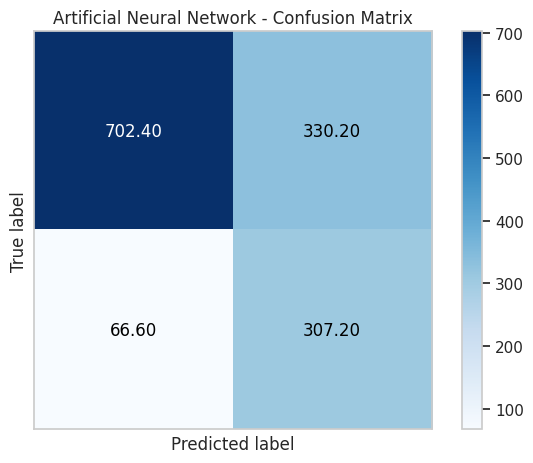


Area under ROC Curve: 0.8359410624715002



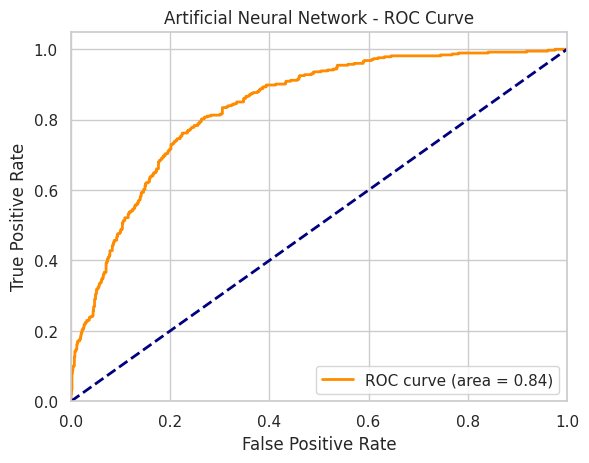

In [ ]:
# Define the ANN model
ann_model = MLPClassifier(random_state=39)

# Train and test the model, and print evaluation metrics
trainTestAndPlot('Artificial Neural Network', ann_model)

**Why was this algorithm chosen ?**

ANN can capture the non linear relationships in the telco customer churn dataset and can recognise complex patterns.

**How does this algorithm perform on our dataset?**
The TPR is high with 0.82 and the FPR is also high (0.32) which means the model has large number of false alarms.

**Why was the performance moderate?**
We have not customized the ANN with hyperparameters like activation function, regularization method that can optimise model performance.

# Comparing Models

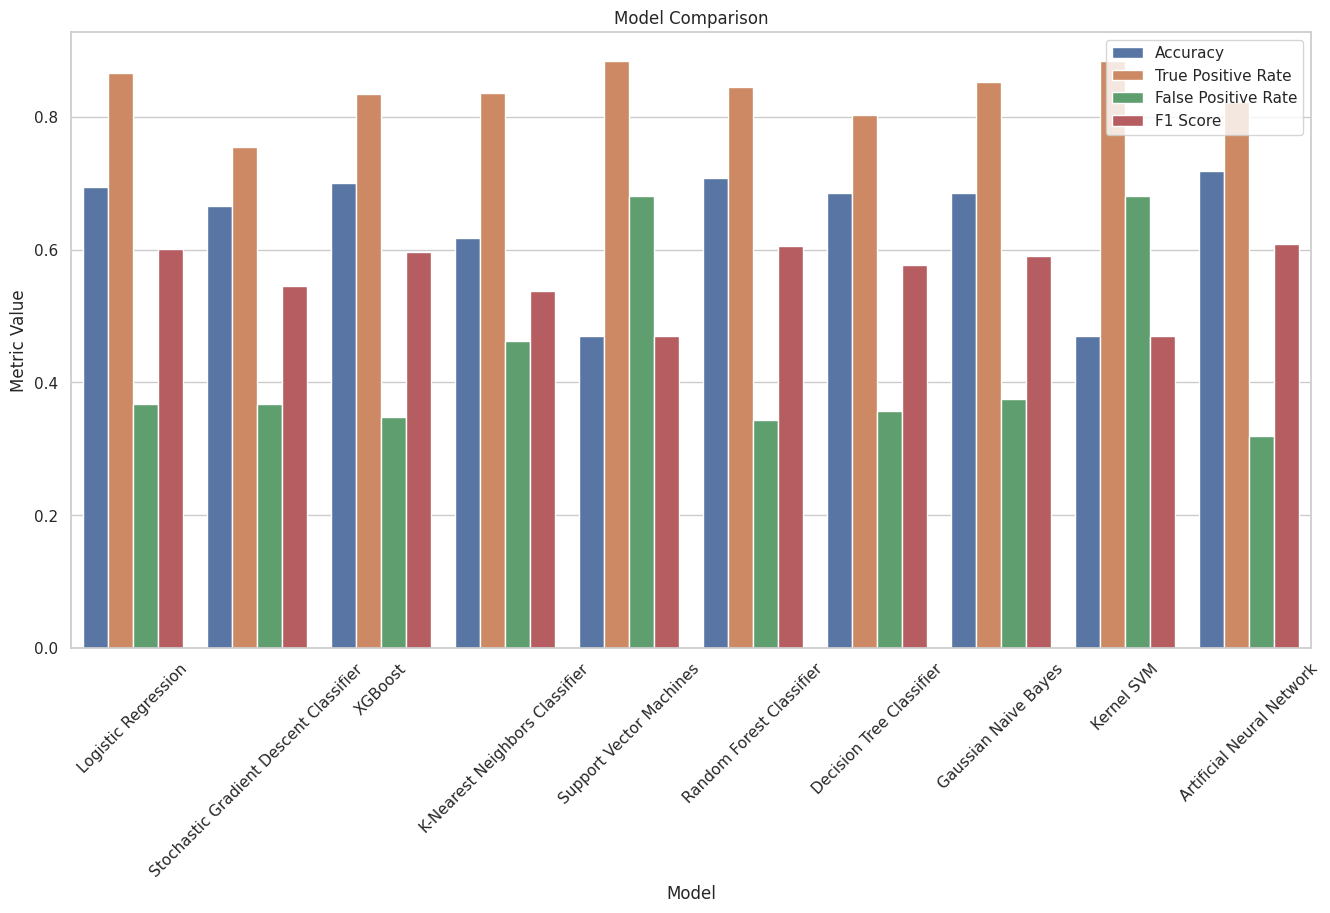

In [ ]:
# Plot and compare
# Convert the modelDict to a pandas DataFrame
model_df = pd.DataFrame(modelDict).T.reset_index().rename(columns={"index": "Model"})
melted_df = model_df.melt(id_vars=['Model'], var_name='Metric', value_name='Value')
# Create a bar plot
plt.figure(figsize=(16, 8))
sns.barplot(x='Model', y='Value', hue='Metric', data=melted_df)
plt.title('Model Comparison')
plt.xlabel('Model')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.legend(loc='upper right')
plt.show()

Inferences:


*   ANN gives the best accuracy.
*   KNN and Kervel SVM have a high TPR
*   ANN has the lowest FPR
*   ANN has the highest F1 score

Overall performance of ANN is better than all other algorithms. ANN captures the  complex non-linear relationships between features and Churn.

